In [9]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
import string
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens


import sklearn.feature_selection as feature_selection

#### Plotting Helper functions

In [10]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, title='', length_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        for i, lab in enumerate(bars):
            labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        ax.set_xticklabels(cols)
        if not length_label=='':
            ax.set_ylabel(length_label)
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        ax.set_yticklabels(cols)
        if not length_label=='':
            ax.set_xlabel(length_label)
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title)
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=True,
                annot_kws={'size': 8})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
    """Plots confusion matrix
    Parameters:
    ax =  matplotlib axes
    normalyze = normalization over truth (number_predicted / total_count_of_this_class)
    """
    model.fit(X,y)
    conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                              labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
    classes = y.unique()
    classes.sort()
    n_classes = [len(y[y == c]) for c in classes]
    if normalize == True:
        n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
        norm_matrix = conf_matrix / np.array(n_classes)
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               ns_matrix[i, j]) for j, v in
                            enumerate(norm_matrix[i])]
                           for i, v in enumerate(norm_matrix)])

        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values

#### Helper functions for model training

In [11]:
# Tune parameters
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = model_selection.GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

# Cross-validation report
def cv_rep(model, X, y, cv, scoring):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

# Tune model parameters and print CV report
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

# Tune model parameters and print CV report for calibrated classifier model
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

### Import data

In [12]:
#import train dataset
filename_tr = 'train.csv'
data_train = pd.read_csv(filename_tr)

#import test dataset
filename_tes = 'test.csv'
data_test = pd.read_csv(filename_tes)

#### Training Set

In [13]:
data_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Test Set

In [14]:
data_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Checking missing values in training set

In [15]:
nulls = data_train.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
N = len(data_train.index)
nulls.insert(1, 'percent', ['{0:.2%}'.format(nulls.loc['Age'][0] / N), 
                            '{0:.2%}'.format(nulls.loc['Cabin'][0] / N),
                            '{0:.2%}'.format(nulls.loc['Embarked'][0] / N)])
nulls

,count,percent
Age,177,19.87%
Cabin,687,77.10%
Embarked,2,0.22%


Seems to be a lot of missing values in 'Age' and 'Cabin'.

As I concluded from preliminary analysis, the Age is one of the critical and must be treated first.

The Cabin and Embarked are probably not important in Survival prediction.

I will come to nulls later but for now lets look on distributions.

#### Checking missing values in test set

In [16]:
nulls = data_test.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
nulls

,count
Age,86
Fare,1
Cabin,327


There is one missing value for ticket fare. For now I will assign it a zero.

In [17]:
data_test = data_test.fillna(value={'Fare':0})

#### Calculate survival rate

In [18]:
#how many died
N_surv0 = len(data_train.loc[data_train['Survived']==0])
#how many survived
N_surv1 = len(data_train.loc[data_train['Survived']==1])

print('Deads: {0} ({1:.2%})'.format(N_surv0, N_surv0 / N))
print('Survivals: {0} ({1:.2%})'.format(N_surv1, N_surv1 / N))

Deads: 549 (61.62%)
Survivals: 342 (38.38%)


Well, only 1/3 survived. That was expectable though.

#### Replace 'Name' with encoded titles

In [19]:
#Concatinate train & test data (to make sure that all unique titles are captured)
data_tot = pd.concat([data_train, data_test], ignore_index=True)

In [20]:
#Encode 'Name'
def name_encoder(data):
    data_encoded = []
    for i in data['Name']:
        lname0 = i.split(',')[0].strip() #last name
        ttl = i.split(',')[1].split('.')[0].strip() #title
        lname1 = (i.split('(')[-1].split(')')[0].split()[-1].strip() if '(' in i else '').replace('\"','') #second last name
        data_encoded.append([lname0, lname1, ttl])
    data_encoded = pd.DataFrame(data_encoded, columns=['lname0', 'lname1', 'ttl'], index=data.index)
    return pd.concat([data.reset_index(drop=True), data_encoded], axis=1)

In [21]:
df_name = name_encoder(data_tot['Name'].to_frame())
df_name.head(5)

,Name,lname0,lname1,ttl
0,"Braund, Mr. Owen Harris",Braund,,Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,Thayer,Mrs
2,"Heikkinen, Miss. Laina",Heikkinen,,Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,Peel,Mrs
4,"Allen, Mr. William Henry",Allen,,Mr


In [22]:
#Find unique titles and their counts
ttl = df_name['ttl'].unique()
ttl = pd.DataFrame([[i, len(df_name.loc[df_name['ttl']==i])] for i in ttl], columns=['ttl', 'ttl_n'])
ttl.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
ttl,Mr,Mrs,Miss,Master,Don,Rev,Dr,Mme,Ms,Major,Lady,Sir,Mlle,Col,Capt,the Countess,Jonkheer,Dona
ttl_n,757,197,260,61,1,8,8,1,2,2,1,1,2,4,1,1,1,1


In [23]:
#Explore samples with 'Dr' title
df_name.loc[df_name['ttl']=='Dr']

,Name,lname0,lname1,ttl
245,"Minahan, Dr. William Edward",Minahan,,Dr
317,"Moraweck, Dr. Ernest",Moraweck,,Dr
398,"Pain, Dr. Alfred",Pain,,Dr
632,"Stahelin-Maeglin, Dr. Max",Stahelin-Maeglin,,Dr
660,"Frauenthal, Dr. Henry William",Frauenthal,,Dr
766,"Brewe, Dr. Arthur Jackson",Brewe,,Dr
796,"Leader, Dr. Alice (Farnham)",Leader,Farnham,Dr
1184,"Dodge, Dr. Washington",Dodge,,Dr


_**Leader, Dr. Alice (Farnham) is only one woman with title 'Dr'._

The function below will replace each person's name with encoded title. Instead of using all unique titles, I will teke only these: 'Mr', 'Mrs', 'Miss' and 'Master'.

In [24]:
def title_encoder(data):
    mask = {'Don':'Mr',
            'Sir':'Mr',
            'Jonkheer':'Mr',
            'Mme':'Mrs',
            'Lady':'Mrs',
            'the Countess':'Mrs',
            'Dona':'Mrs',
            'Mlle':'Miss',
            'Ms':'Miss',
            'Major':'Mr',
            'Col':'Mr',
            'Capt':'Mr',
            'Rev':'Mr',
            'Dr':'Mr'}
    
    data = name_encoder(data)
    data['ttl'] = data['ttl'].apply(lambda i: mask[i] if i in mask else i)
#     df = data['ttl'].apply(lambda i: mask[i] if i in mask else i)
#     data = pd.concat([data.drop(columns=['ttl']), df], axis=1)
    if 797 in data['PassengerId'].values:
        data.loc[data_tot['PassengerId']==797, 'ttl'] = 'Mrs'
    mask = {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4}
    data['ttl'] = data['ttl'].apply(lambda i: mask[i])
#     df = data['ttl'].apply(lambda i: mask[i])
#     return pd.concat([data.drop(columns=['ttl']), df], axis=1)
    return data

#### Explore missing values for 'Embarked'

In [25]:
data_tot.loc[data_tot['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Display samples with similar ticket number

In [26]:
df = data_tot.query('Ticket.str.contains("1135")')
df.sort_values(by='Ticket')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
782,783,0.0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S
377,378,0.0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C
965,966,NaN,1,"Geiger, Miss. Amalie",female,35.0,0,0,113503,211.5000,C130,C
966,967,NaN,1,"Keeping, Mr. Edwin",male,32.5,0,0,113503,211.5000,C132,C
1109,1110,NaN,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.5000,C80,C
1298,1299,NaN,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C
166,167,1.0,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S
356,357,1.0,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S
54,55,0.0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
917,918,NaN,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C


All people with similar ticket numbers are embarked in 'C' or 'S'. So i will simply assign the most frequent class to both missed values.

In [27]:
nc = len(df.loc[df['Embarked']=='C'])
ns = len(df.loc[df['Embarked']=='S'])
n = len(df.index)

print('C: %d' % nc)
print('S: %d' % ns)
print('All: %d' % n)

C: 7
S: 5
All: 14


The function below will be used to encode 'Embarked' variable

In [28]:
#Encoding 'Embarked'
def embarked_encoder(data):
    if len(data.loc[data['Embarked'].isnull()].index)>0:
        data = data.fillna(value={'Embarked':'C'})
    mask = {'C':0, 'S':1, 'Q':2}
    data['Embarked'] = data['Embarked'].apply(lambda i: mask[i])
    return data

### Grouping by ticket ID

While exploring the dataset, I found that many passengers have identical ticket numbers as well as identical fare value.

In this section, for all people with matching tickets, I will recalculate ticket fare for every i-th person in a group g as: fare(i, g) = fare(g) / n, where n is a number of people in group g.

In [29]:
# Clean text function
def clean_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]).strip()
    text = ''.join(text.split())
    return text

# This function will clean ticket ID from all punctuation and spaces
# def ticket_cleaner(data):
#     data['Ticket'] = data['Ticket'].apply(lambda i: clean_text(i))
# #     df = data['Ticket'].apply(lambda i: clean_text(i)).to_frame()
# #     data = pd.concat([data.drop(columns=['Ticket']).reset_index(drop=True), df], axis=1)
#     return data

# Clean ticket ID from all punctuation and spaces
df_fam = data_tot.copy()
df_fam['Ticket'] = df_fam['Ticket'].apply(lambda i: clean_text(i))

In [30]:
# df_fam = ticket_cleaner(data_tot)

Numbers of unique and non-unique tickets:

In [31]:
print('Unique tickets: %d' % len(df_fam['Ticket'].unique()))
print('Non-unique tickets: %d' % (len(df_fam.index) - len(df_fam['Ticket'].unique())))

Unique tickets: 929
Non-unique tickets: 380


I want to define the following groups:
1. No family (SibSp==0 & Parch==0), unique tickets
2. No family (SibSp==0 & Parch==0), non-unique tickets
3. Has family, no children (SibSp >0 & Parch==0), unique tickets
4. Has family, no children (SibSp >0 & Parch==0), non-unique tickets
5. Has family, has children (Parch >0), unique tickets
6. Has family, has children (Parch >0), non-unique tickets

In [32]:
families0 = df_fam.loc[(df_fam['SibSp']>0) & (df_fam['Parch']==0)]
families1 = df_fam.loc[df_fam['Parch']>0]
singles = df_fam.loc[(df_fam['SibSp']==0) & (df_fam['Parch']==0)]

In [33]:
# This function is used to return sub-groups by unique and non-unique tickets from a group by SibSP and Parch
def grps_by_size(grp):
    #group size > 1
    grp1 = None
    #group size == 1
    grp0 = None
    for g in grp.groups:
        grp_ = grp.get_group(g)
        if len(grp.get_group(g).index)>1:
            if grp1 is None:
                grp1 = grp_
            else:
                grp1 = pd.concat([grp1, grp_])
        else:
            if grp0 is None:
                grp0 = grp_
            else:
                grp0 = pd.concat([grp0, grp_])
    return (grp0, grp1)

In [34]:
#singles
sig_grp = singles.groupby('Ticket')
#families NO children
fam0_grp = families0.groupby('Ticket')
#families w/children
fam1_grp = families1.groupby('Ticket')

#no family, unique ticket
sig0 = grps_by_size(sig_grp)[0]
#no family, matching tickets
sig1 = grps_by_size(sig_grp)[1]
#has family, no children, unique ticket
fam0 = grps_by_size(fam0_grp)[0]
#has family, no children, matching ticket
fam1 = grps_by_size(fam0_grp)[1]
#has family, has children, unique ticket
famch0 = grps_by_size(fam1_grp)[0]
#has family, has children, matching ticket
famch1 = grps_by_size(fam1_grp)[1]

print('Singles-----------------------')
print('Matching tickets groups: %d' % len(sig1.index))
print('Unique tickets groups: %d' % len(sig0.index))
print('------------------------------')

print('Families----------------------')
print('Matching tickets groups: %d' % len(fam1.index))
print('Unique tickets groups: %d' % len(fam0.index))
print('------------------------------')

print('Families W/children-----------')
print('Matching tickets groups: %d' % len(famch1.index))
print('Unique tickets groups: %d' % len(famch0.index))
print('------------------------------')

Singles-----------------------
Matching tickets groups: 108
Unique tickets groups: 682
------------------------------
Families----------------------
Matching tickets groups: 174
Unique tickets groups: 38
------------------------------
Families W/children-----------
Matching tickets groups: 288
Unique tickets groups: 19
------------------------------


In [35]:
# Family groups
fam_grps = [sig0, sig1, fam0, fam1, famch0, famch1]

In [36]:
# Make a mask of family groups labels
fgrp_mask = {}
for idx, grp in enumerate(fam_grps):
    for pid in grp['PassengerId']:
        fgrp_mask[pid] = idx

In [37]:
# Make a mask of ticket fare
fare_mask = {}
for tic in df_fam['Ticket'].unique():
    # subgroup with matching tickets
    tic_grp = df_fam.loc[df_fam['Ticket']==tic]
    
    # passenger class that the subgroup belongs to
    c = tic_grp['Pclass'].values[0]
    
    # ticket fare of the subgroup
    # all subgroup members have the same ticket fare initially
    fare_grp = tic_grp['Fare'].values[0]
    
    # if a subgroup fare is 0 then assign a mean of the fare of the Pclass that the subgroup belongs to
    if (fare_grp == 0) or (fare_grp is None):
        fare_i = np.mean(df_fam.loc[df_fam['Pclass']==c, 'Fare'])
        for pid in tic_grp['PassengerId']:
            fare_mask[pid] = fare_i

    # recalculate fare for subrgoup members: fare_i = group_fare / n_members
    if len(tic_grp.index) > 1:
        if fare_grp > 0:
            
            if np.mean(tic_grp['Fare'])==fare_grp: #check if all group members have same fare
                fare_i = fare_grp / len(tic_grp.index)
                for pid in tic_grp['PassengerId']:
                    fare_mask[pid] = fare_i
            else:
                for pid in tic_grp['PassengerId']:
                    fare_mask[pid] = tic_grp.loc[tic_grp['PassengerId']==pid, 'Fare'].values[0]
    # keep fare value for passengers with unuque tickets
    else:
        if fare_grp > 0:
            fare_i = fare_grp
            for pid in tic_grp['PassengerId']:
                fare_mask[pid] = fare_i

In [38]:
# Make a mask of ticket codes
m_tickets = []
for tic in df_fam['Ticket'].unique():
    if len(df_fam.loc[df_fam['Ticket']==tic].index) > 1:
        m_tickets.append(tic)

ticket_mask = {}        
for pid in df_fam['PassengerId']:
    tic = df_fam.loc[df_fam['PassengerId']==pid, 'Ticket'].values[0]
    if tic in m_tickets:
        ticket_mask[pid] = m_tickets.index(tic) + 1
    else:
        ticket_mask[pid] = 0

In [39]:
# Encode family groups
# This function adds new class variable 'fgrp' that indicates a group that a passenger belongs to.
# def family_groups_encoder(data, fam_grps):
#     data['fgrp'] = 0
#     for idx, grp in enumerate(fam_grps):
#         for pid in grp['PassengerId']:
#             data.loc[data['PassengerId']==pid, 'fgrp'] = idx
#     return data

def family_groups_encoder(data, fgrp_mask):
    data['fgrp'] = data['PassengerId'].apply(lambda i: fgrp_mask[i])
    return data

# Recalculate ticket fare in the family groups and fill missing values with a mean for corresponding passenger class.
# def fare_encoder(data, encode_grps):
#     for grp in encode_grps:
#         fare = grp['Fare'].values[0] / len(grp.index)
#         grp['Fare'] = fare
#         for pid in grp['PassengerId']:
#             if pid in data['PassengerId']:
#                 data.loc[data['PassengerId']==pid, 'Fare'] = fare
#     if len(data.loc[data['Fare'].isnull()])>0:
#         for pid in data.loc[data['Fare'].isnull(), 'PassengerId']:
#             c = data.loc[data['PassengerId']==pid, 'Pclass'].values[0]
#             data.loc[data['PassengerId']==pid, 'Fare'] = np.mean(data.loc[data['Pclass']==c, 'Fare'])
#     return data

# def fare_encoder(data, encode_grps):
#     for grp in encode_grps:
#         for tic in grp['Ticket'].unique():
#             tic_grp = grp.loc[grp['Ticket']==tic]
#             fare_grp = tic_grp['Fare'].values[0]
#             c = tic_grp['Pclass'].values[0]
#             if len(tic_grp.index) > 1:
#                 if fare_grp > 0:
#                     fare_i = fare_grp / len(tic_grp.index)
#                 else:
#                     fare_i = np.mean(data.loc[data['Pclass']==c, 'Fare'])
#             else:
#                 if fare == 0:
#                     fare_i = np.mean(data.loc[data['Pclass']==c, 'Fare'])       
#             for idx, row in tic_grp.iterrows():
#                 data.loc[data['PassengerId']==row['PassengerId'], 'Fare'] = fare_i
#     return data

# def fare_encoder(data):
#     for tic in data['Ticket'].unique():
#         tic_grp = data.loc[data['Ticket']==tic]
        
#         c = tic_grp['Pclass'].values[0]
        
#         fare_grp = tic_grp['Fare'].values[0]
#         if fare_grp == 0:
#             fare_i = np.mean(data.loc[data['Pclass']==c, 'Fare'])
#             for idx, row in tic_grp.iterrows():
#                 data.loc[data['PassengerId']==row['PassengerId'], 'Fare'] = fare_i
            
        
#         if len(tic_grp.index) > 1:
#             if fare_grp > 0:
#                 fare_i = fare_grp / len(tic_grp.index)
#                 for idx, row in tic_grp.iterrows():
#                     data.loc[data['PassengerId']==row['PassengerId'], 'Fare'] = fare_i
#     return data

def fare_encoder(data, fare_mask):
    data['Fare'] = data['PassengerId'].apply(lambda i: fare_mask[i])
    return data

# def cabin_encoder(data):
#     cab_na = data.loc[data['Cabin'].isnull()]
#     for tic in data['Ticket'].unique():
#         tic_grp = data.loc[data['Ticket']==tic] 
# #         if len(tic_grp.index) > 1:
# #             cab_grp = tic_grp['Cabin'].values[0]
#         for idx, row in tic_grp.iterrows():
#             if row['Cabin'] is None:
#                 data.loc[data['PassengerId']==row['PassengerId'], 'Cabin'] = row['Ticket']
#     return data

def ticket_encoder(data, ticket_mask):
    data['Ticket'] = data['PassengerId'].apply(lambda i: ticket_mask[i])
    return data

### Combine Pclass and Embarked

The 'Pclass' and 'Embarked' variables are highly correlated. And 'Embarked' is actually not as important as the 'Pclass'.

In order to make them work together more effectively, I will combine them into a single variable. This new variable will be defined in a 3x3 matrix according to combinations of 'Pclass' and 'Embarked' labels.

| Embarked / Pclass | 0 | 1 | 2 |
|:-----------------:|---|---|---|
| 0                 | 0 | 1 | 2 |
| 1                 | 3 | 4 | 5 |
| 2                 | 6 | 7 | 8 |

Below is a function that does the work.

In [40]:
# Combine categorical features
def combine_features(data, feature1, feature2, name):
    lst1 = list(data[feature1].unique())
    lst2 = list(data[feature2].unique())
    d1 = len(lst1)
    d2 = len(lst2)
    mask = np.array(range(d1 * d2)).reshape(d1,d2)
    data = data.copy()
    df = []
    for i in data.index:
        df.append([mask[lst1.index(data[feature1][i])][lst2.index(data[feature2][i])]])
    df = pd.DataFrame(df, columns=[name])
    return pd.concat([data.reset_index(), df], axis=1).drop(columns='index')

### Numerical features augmentation (magic features)

This is a simple feature transformation in order to account for counts of non-unique values.

More info on magic features is [here](https://www.kaggle.com/cdeotte/200-magical-models-santander-0-920). 

In [41]:
# Transform 'Age to account for non-unique samples'
def age_transformer_counts(data):
    data['Age'] = data['Age'].apply(np.log)
#     data['Age'] = data['Age'].apply(lambda i: np.log(i * len(data.loc[data['Age']==i].index)))
    return data

# Transform 'Fare' to account for number of non-unique samples
def fare_transformer(data):
    data['Fare'] = data['Fare'].apply(np.log)
#     data['Fare'] = data['Fare'].apply(lambda i: np.log(i * len(data.loc[data['Fare']==i].index)))
    return data

### Other variables encoding

In [42]:
# Encode 'Sex'
def sex_encoder(data):
    mask = {'male':0, 'female':1}
    df = data['Sex'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['Sex']), df], axis=1)

# Add 'Family size'
def fam_size(data):
    data['famsize'] = data['SibSp'] + data['Parch']
    data['famsize'] = data['famsize'].apply(lambda i: i if i<8 else 8)
    return data

#Encoding 'Pclass' (to labels 0,1,2)
def pclass_encoder(data):
    data['Pclass'] = data['Pclass'].apply(lambda i: i-1)
    return data

### Age augmentation

I want to use 2-step approach to predict missing values for Age.

1. Use BayesianGaussianMixture to define clusters in the existing Age data and then train a classifier that will predict these cluster labels based on other features.
2. Train a regression model that will predict Age values based on existing features and Age class labels.

In [84]:
# Log + 1 - Transform 'Age'
df_age = data_tot['Age'].dropna()

age_trans = df_age.apply(lambda i: np.log(i)).to_frame()
age_trans.columns = ['Age_trans']
df_age = pd.concat([df_age.to_frame(), age_trans], axis=1)

In [85]:
#Define clustering model
age_clast_model = mix.BayesianGaussianMixture(n_components=2, covariance_type='spherical', tol=0.001, reg_covar=1e-06, max_iter=1000, n_init=1, 
                                 init_params='kmeans', weight_concentration_prior_type='dirichlet_distribution', 
                                 weight_concentration_prior=None, mean_precision_prior=None, mean_prior=None, 
                                 degrees_of_freedom_prior=None, covariance_prior=None, random_state=30)
                                 
#Predict cluster labels
age_cls = pd.DataFrame(age_clast_model.fit_predict(np.array(df_age['Age_trans']).reshape(-1,1)), columns=['Age_cls'])
age_cls = age_cls.astype(int)

In [86]:
# Add age class labels to the data set
df_age = pd.concat([df_age.reset_index(), age_cls], axis=1).drop(columns='index')

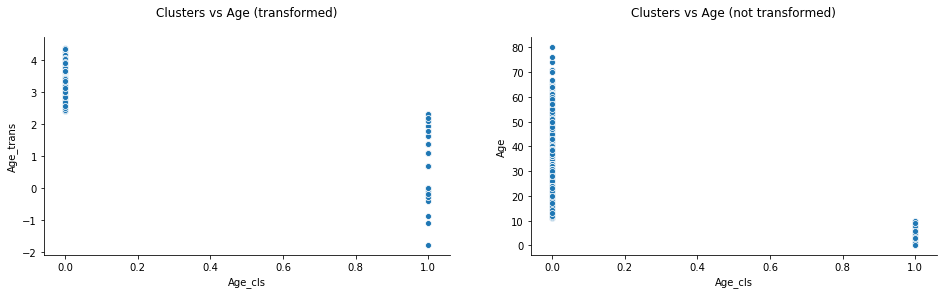

In [87]:
fig = plt.figure()
fig.set_size_inches(16,4)

fig.add_subplot(1,2,1)
ax = sns.scatterplot(x='Age_cls', y='Age_trans', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (transformed)')

fig.add_subplot(1,2,2)
ax = sns.scatterplot(x='Age_cls', y='Age', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (not transformed)')

#### Distributions within clasters (age - transformed)

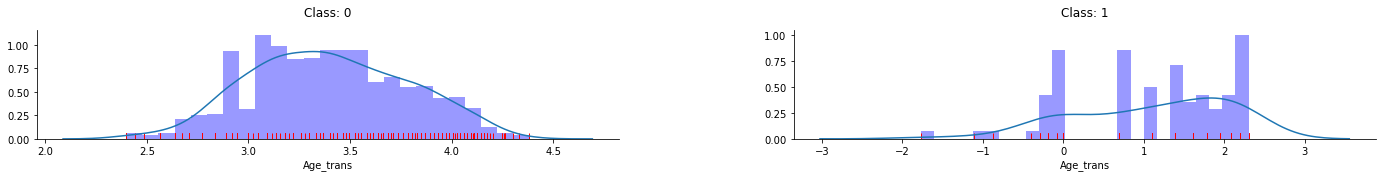

In [88]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age_trans']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

#### Distributions within clasters (age - not transformed)

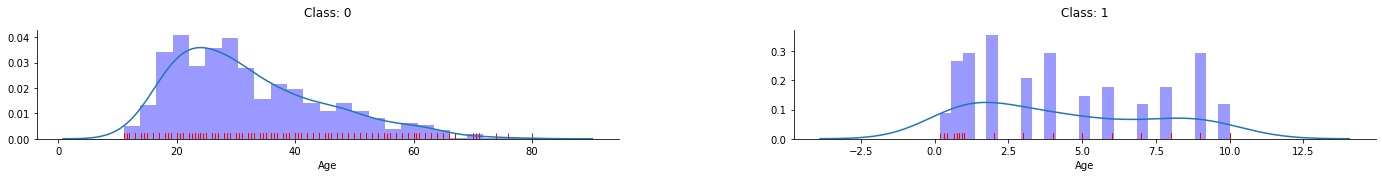

In [89]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

In [77]:
def age_transformer(data, model):
    age_trans = np.array(data['Age'].apply(lambda i: np.log(i))).reshape(-1,1)
    age_cls = pd.DataFrame(model.fit_predict(age_trans), columns=['Age_cls'])
    age_cls = age_cls.astype(int)
    data = pd.concat([data.drop(columns=['Age']).reset_index(), pd.DataFrame(age_trans, columns=['Age'])], axis=1).drop(columns='index')
    return pd.concat([data.reset_index(), age_cls], axis=1).drop(columns='index')

### Predict missing missing values for age

In [78]:
data = family_groups_encoder(data_tot.copy(), fgrp_mask)
# data = fare_encoder(data, [sig1, fam1, famch1])
data = fare_encoder(data, fare_mask)
data = fare_transformer(data)

data = ticket_encoder(data, ticket_mask)

data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)

data = embarked_encoder(data)
data = pclass_encoder(data)
data = combine_features(data, 'Pclass', 'Embarked', 'PclEmb')

data = data[data['Age'].notna()].copy()
# data = data[['Age', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Cabin', 'PassengerId']]

data = age_transformer(data, age_clast_model)

data = data[['Age', 'Age_cls', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket']]

In [79]:
# data = cabin_encoder(data)

#### Plot correlation matrix:

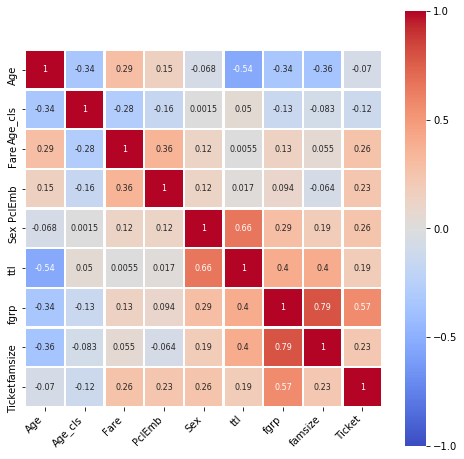

In [80]:
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

#### Train model for age class prediction

In [81]:
# Here I drop 'Sex' as it is completely covered by 'ttl'.
# I also drop 'famsize' as it is highly correlated with 'fgrp' and eventually was found to be less important.
# TO DO: try to combine 'fgrp' and 'famsize'
X = data.drop(columns=['Age', 'Age_cls', 'Sex', 'famsize', 'Ticket'])
y = data['Age_cls']

In [82]:
#common random_state
random_state=30

#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)

#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'balanced_accuracy'

##### Initial model

In [83]:
params = {'learning_rate': 1.1183673469387756, 
          'n_estimators': 5,
          'min_weight_fraction_leaf': 0.03671794871794872, 
          'min_impurity_decrease': 0.0001,
          'max_depth': 4,
          'subsample': 1.0,
          'ccp_alpha': 0.0}

age_cls_model = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                               random_state=random_state, **params)
cv_rep(age_cls_model, X, y, cv, scoring)

ValueError: multiclass format is not supported

##### Tune parameters

In [48]:
param_ranges = {'learning_rate': np.linspace(0.2, 2, 99), 'n_estimators': np.arange(5, 100, 99)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.974839  0.995139         0.922207
std_train            0.004978  0.001205         0.017015
mean_test            0.972720  0.991453         0.915381
std_test             0.013573  0.003729         0.019820
{'learning_rate': 1.1734693877551021, 'n_estimators': 5}


In [49]:
param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.0001, 0.1, 40)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.974839  0.977339         0.903897
std_train            0.004978  0.003790         0.066307
mean_test            0.972720  0.965010         0.845029
std_test             0.013573  0.018567         0.063066
{'min_impurity_decrease': 0.0001, 'min_weight_fraction_leaf': 0.03671794871794872}


In [50]:
param_ranges = {'subsample': np.linspace(0.1, 1.0, 50), 'max_depth': np.arange(3, 10)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.975627  0.980082         0.848089
std_train            0.004506  0.006310         0.013628
mean_test            0.974720  0.972291         0.834804
std_test             0.008909  0.012900         0.017796
{'max_depth': 4, 'subsample': 0.9816326530612246}


In [51]:
param_ranges = {'ccp_alpha': np.linspace(0.00001,0.0001, 99)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.975627  0.977336         0.848089
std_train            0.004506  0.003588         0.013628
mean_test            0.974720  0.968208         0.834804
std_test             0.008909  0.011163         0.017796
{'ccp_alpha': 1e-05}


In [52]:
age_cls_model.fit(X,y)

GradientBoostingClassifier(ccp_alpha=1e-05, criterion='friedman_mse', init=None,
                           learning_rate=1.1734693877551021, loss='deviance',
                           max_depth=4, max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0001,
                           min_impurity_split=None, min_samples_leaf=1,
                           min_samples_split=2,
                           min_weight_fraction_leaf=0.03671794871794872,
                           n_estimators=5, n_iter_no_change=None,
                           presort='deprecated', random_state=30,
                           subsample=0.9816326530612246, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Train model for age prediction

In [69]:
# train test split
X = data.drop(columns=['Age', 'Sex'])
y = data['Age']

In [54]:
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)
#cross validation metrics
scoring = {'explained_variance':  'explained_variance', 'r2': 'r2'}
refit='r2'

##### Initial model

In [55]:
params = {'learning_rate': 0.09769230769230769, 
          'n_estimators': 80,
          'min_weight_fraction_leaf': 0.02141025641025641, 
          'min_impurity_decrease': 0.18012820512820513,
          'max_depth': 4,
          'subsample': 1.0,
          'ccp_alpha': 0.0001}

age_reg_mogel = ens.GradientBoostingRegressor(loss='ls', criterion='friedman_mse', random_state=random_state, **params)
cv_rep(age_reg_mogel, X, y, cv, scoring)

,explained_variance,r2
mean_train,0.787116,0.787116
std_train,0.011373,0.011373
mean_test,0.714922,0.713372
std_test,0.061712,0.062098


##### Tune parameters

In [56]:
param_ranges = {'learning_rate': np.linspace(0.01, 0.1, 40), 'n_estimators': np.arange(5, 100, 25)}
age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.785912  0.785912
std_train             0.011407  0.011407
mean_test             0.715282  0.713738
std_test              0.061238  0.061601
{'learning_rate': 0.05615384615384616, 'n_estimators': 80}


In [57]:
param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.001, 0.5, 40)}
age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.785912  0.785912
std_train             0.011407  0.011407
mean_test             0.715282  0.713738
std_test              0.061238  0.061601
{'min_impurity_decrease': 0.18012820512820513, 'min_weight_fraction_leaf': 0.02141025641025641}


In [58]:
param_ranges = {'max_depth': np.arange(2,10), 'subsample': np.linspace(0.1, 1.0, 50)}
age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.793154  0.793153
std_train             0.010893  0.010893
mean_test             0.715598  0.713987
std_test              0.060739  0.061097
{'max_depth': 5, 'subsample': 0.963265306122449}


In [59]:
param_ranges = {'ccp_alpha': np.linspace(0.0001, 0.01, 99)}
age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.786377  0.786377
std_train             0.011437  0.011437
mean_test             0.715785  0.714194
std_test              0.060578  0.060919
{'ccp_alpha': 0.0005040816326530613}


In [60]:
age_reg_mogel.fit(X,y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0005040816326530613,
                          criterion='friedman_mse', init=None,
                          learning_rate=0.05615384615384616, loss='ls',
                          max_depth=5, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.18012820512820513,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2,
                          min_weight_fraction_leaf=0.02141025641025641,
                          n_estimators=80, n_iter_no_change=None,
                          presort='deprecated', random_state=30,
                          subsample=0.963265306122449, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [76]:
#Age encoder (predict missing vakues and log-transform)
def age_predictor(data, age_cls_model, age_reg_mogel):
    cls_cols = ['Fare', 'PclEmb', 'ttl', 'fgrp']
    reg_cols = ['Fare', 'PclEmb', 'ttl', 'fgrp', 'famsize', 'Ticket']
    data_na = data[data['Age'].isnull()]
    data_notna = data[data['Age'].notna()].copy()

    # transform non-null age values
#     age_trans = data_notna['Age'].apply(lambda i: np.log(i+1)).to_frame()
#     age_trans = data_notna['Age'].apply(np.log).to_frame()
#     data_notna = pd.concat([data_notna.drop(columns=['Age']), age_trans], axis=1)
    data_notna['Age'] = data_notna['Age'].apply(np.log)

    # predict class labels
    X = data_na[cls_cols].reset_index(drop=True)
    age_cls = pd.Series(age_cls_model.predict(X), name='Age_cls').to_frame()

    # predict age
    X = data_na[reg_cols].reset_index(drop=True)
    X_age_cls = pd.concat([X, age_cls], axis=1)
    age_preds = pd.Series(age_reg_mogel.predict(X_age_cls), name='Age').to_frame()
    data_na = pd.concat([data_na.reset_index(drop=True).drop(columns=['Age']), age_preds], axis=1)
    return pd.concat([data_na, data_notna])

## Predict survivals

#### Preprocessind data

In [62]:
# data = family_groups_encoder(data_train, fam_grps)
# data = fare_encoder(data, [sig1, fam1, famch1])
# data = fare_transformer(data)

# data = title_encoder(data)
# data = sex_encoder(data)
# data = fam_size(data)

# data = embarked_encoder(data)
# data = pclass_encoder(data)
# data = combine_features(data, 'Pclass', 'Embarked', 'PclEmb')

# data = data[['PassengerId', 'Survived', 'Fare', 'Age', 'ttl', 'famsize', 'PclEmb', 'fgrp']]

# data = age_predictor(data, age_cls_model, age_reg_mogel)
# data = age_transformer_counts(data)

In [63]:
# def family_encoder(data):
# #     data = data.copy()
# #     data['mtickets'] = 0
# #     data['famsize'] = data['SibSp'] + data['Parch']
#     data['SibSp'] = data['SibSp'].apply(lambda i: 1 if i > 0 else 0)
#     data['Parch'] = data['Parch'].apply(lambda i: 1 if i > 0 else 0)
# #     for pid in data['PassengerId']:
# #         for grp in match_ticket_grps:
# #             if pid in grp['PassengerId']:
# #                 data.loc[data['PassengerId']==pid, 'mtickets'] = 1
#     return data

In [164]:
data = family_groups_encoder(data_train.copy(), fgrp_mask)
# data = family_encoder(data)
# data = fare_encoder(data, [sig1, fam1, famch1])
data = fare_encoder(data, fare_mask)
data = fare_transformer(data)

data = ticket_encoder(data, ticket_mask)

data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)

data = embarked_encoder(data)
data = pclass_encoder(data)
data = combine_features(data, 'Pclass', 'Embarked', 'PclEmb')

# data = data[data['Age'].notna()].copy()
# data = data[['Age', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Cabin', 'PassengerId']]

data = age_predictor(data, age_cls_model, age_reg_mogel)
# data = age_transformer(data, age_clast_model)
# data = data[['PassengerId', 'Survived', 'Fare', 'Age', 'ttl', 'famsize', 'PclEmb', 'fgrp']]
data = data[['PassengerId', 'Survived', 'Age', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket']]

#### Plot correlation matrix:

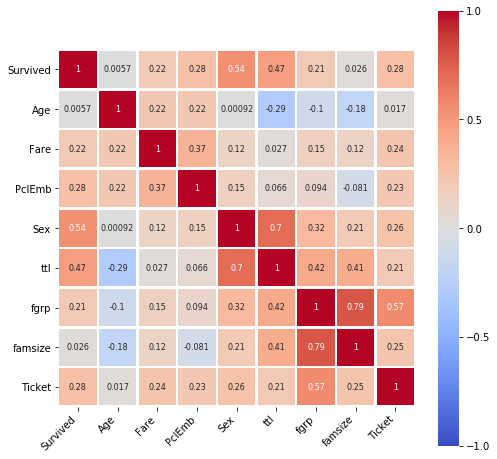

In [165]:
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.drop(columns='PassengerId').corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

#### Train base estimators for stacking model

In [166]:
X = data.drop(columns=['Survived', 'PassengerId'])
y = data['Survived']

In [167]:
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy', 
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'balanced_accuracy'

In [168]:
n = len(y)
class_priors = {}
class_weights = {}
for i in y.unique():
    class_priors[i] = len(y.loc[y==i]) / n
    class_weights[i] = 1- class_priors[i]

In [169]:
base_scores = {}

#### GaussianProcessClassifier

In [170]:
gpc = gaup.GaussianProcessClassifier(random_state=random_state,
                                     kernel=gaup.kernels.RBF(length_scale=1.0,
                                                             length_scale_bounds=(2.0769230769230766,10)),
                                     max_iter_predict=4,
                                     n_restarts_optimizer=5)
scores = cv_rep(gpc, X, y, cv, scoring)
base_scores['gpc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'max_iter_predict': np.arange(1000, 2000, 10)}
# gpc, scores = train_best_model(gpc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.849834  0.881629         0.880619
std_train            0.017850  0.013265         0.017680
mean_test            0.734613  0.816937         0.755035
std_test             0.024683  0.023353         0.026364


In [171]:
param_ranges = {'max_iter_predict': np.arange(1, 12), 'n_restarts_optimizer': np.arange(1, 12)}
gpc, scores = train_best_model(gpc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.849834  0.881766         0.880619
std_train            0.017850  0.013324         0.017680
mean_test            0.734613  0.816955         0.755035
std_test             0.024683  0.023309         0.026364
{'max_iter_predict': 4, 'n_restarts_optimizer': 1}


In [172]:
param_ranges = {'kernel__length_scale': np.linspace(0.001, 0.01, 20), 'kernel__length_scale_bounds': [(i,100) for i in np.linspace(1,3,40)]}
gpc, scores = train_best_model(gpc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.842040  0.880987         0.871322
std_train            0.013740  0.012744         0.012271
mean_test            0.737888  0.817008         0.759152
std_test             0.025475  0.023319         0.026702
{'kernel__length_scale': 0.001, 'kernel__length_scale_bounds': (3.0, 100)}


In [173]:
base_scores['gpc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### LinearDiscriminantAnalysis

In [174]:
lda = disan.LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
scores = cv_rep(lda, X, y, cv, scoring)
base_scores['lda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'n_components': np.arange(1,5)}
# lda, scores = train_best_model(lda, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.805943  0.856018         0.816649
std_train            0.012138  0.013468         0.011422
mean_test            0.792245  0.847799         0.807173
std_test             0.023223  0.022693         0.021403


In [175]:
base_scores['lda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### QuadraticDiscriminantAnalysis

In [176]:
qda = disan.QuadraticDiscriminantAnalysis(priors=[class_priors[0], class_priors[1]], reg_param=0.002010204081632653)
scores = cv_rep(qda, X, y, cv, scoring)
base_scores['qda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'reg_param': np.linspace(0.01,1,12)}
# qda, scores = train_best_model(qda, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.805966  0.859737         0.811166
std_train            0.011844  0.010289         0.012879
mean_test            0.788138  0.847311         0.793857
std_test             0.024518  0.023467         0.026375


In [177]:
param_ranges = {'reg_param': np.linspace(0.001,0.1,99)}
qda, scores = train_best_model(qda, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.808001  0.859526         0.815206
std_train            0.010669  0.009960         0.009971
mean_test            0.788985  0.849011         0.795921
std_test             0.023193  0.023612         0.023913
{'reg_param': 0.011102040816326531}


In [178]:
base_scores['qda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### AdaBoostClassifier

In [179]:
abc = ens.AdaBoostClassifier(algorithm='SAMME.R', 
                             learning_rate=0.056846153846153845,
                             n_estimators=85,
                             random_state=random_state)
scores = cv_rep(abc, X, y, cv, scoring)
base_scores['abc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'n_estimators': np.arange(5, 100, 20), 'learning_rate': np.linspace(0.001, 0.1, 40)}
# abc, scores = train_best_model(abc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.816869  0.876193         0.830044
std_train            0.011416  0.010463         0.010323
mean_test            0.798491  0.860580         0.814595
std_test             0.021722  0.021462         0.022339


In [180]:
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'learning_rate': np.linspace(0.001, 0.1, 40)}
abc, scores = train_best_model(abc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.818392  0.886939         0.831317
std_train            0.011010  0.010112         0.010736
mean_test            0.802736  0.864172         0.819122
std_test             0.024681  0.019670         0.025675
{'learning_rate': 0.06192307692307693, 'n_estimators': 65}


In [181]:
base_scores['abc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

Optimal number of features : 6
Features to drop: 

['Age', 'fgrp']


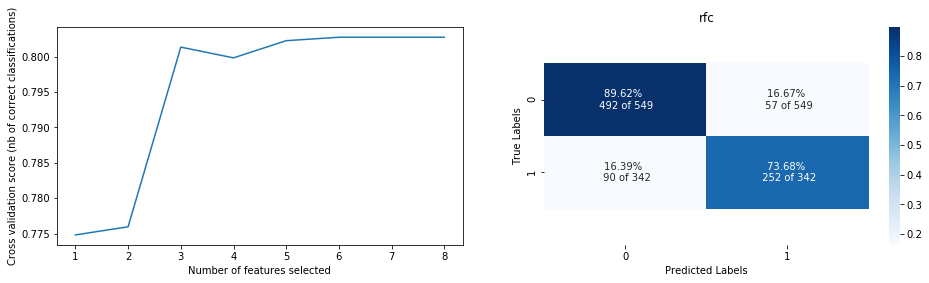

In [182]:
rfecv = feature_selection.RFECV(estimator=abc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(abc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

#### GradientBoostingClassifier

In [183]:
gbc = ens.GradientBoostingClassifier(loss='exponential', 
                                     criterion='friedman_mse', 
                                     learning_rate=0.15084745762711865,
                                     n_estimators=65,
                                     min_impurity_decrease=0.0093076923,
                                     min_weight_fraction_leaf=0.011205128205128204,
                                     max_depth=3,
                                     subsample=1,
                                     ccp_alpha=0.016813,
                                     random_state=random_state)
scores = cv_rep(gbc, X, y, cv, scoring)
base_scores['gbc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'learning_rate': np.linspace(0.01, 0.2, 60), 'n_estimators': np.arange(5, 100, 20)}
# gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.001, 0.1, 20)}
# gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'subsample': np.linspace(0.1, 1.1, 15), 'max_depth': np.arange(3, 6)}
# gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.0001,0.001, 15)}
# gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.817854  0.876521         0.838869
std_train            0.012709  0.015903         0.017045
mean_test            0.795387  0.858720         0.820634
std_test             0.024507  0.021825         0.019874


In [184]:
param_ranges = {'learning_rate': np.linspace(0.01, 0.2, 60), 'n_estimators': np.arange(5, 100, 20)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.818282  0.878127         0.857222
std_train            0.012951  0.014731         0.010448
mean_test            0.795934  0.861733         0.849416
std_test             0.025652  0.020242         0.016543
{'learning_rate': 0.10983050847457626, 'n_estimators': 25}


In [185]:
param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.1, 10, 80)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.818282  0.876430         0.844057
std_train            0.012951  0.015340         0.010613
mean_test            0.795934  0.859129         0.837557
std_test             0.025652  0.021831         0.019112
{'min_impurity_decrease': 0.1, 'min_weight_fraction_leaf': 0.001}


In [186]:
param_ranges = {'subsample': np.linspace(0.1, 1.1, 80), 'max_depth': np.arange(3, 6)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.838297  0.907954         0.866350
std_train            0.016802  0.012223         0.014733
mean_test            0.803566  0.873845         0.837199
std_test             0.020974  0.021260         0.020583
{'max_depth': 4, 'subsample': 0.36582278481012653}


In [187]:
param_ranges = {'ccp_alpha': np.linspace(0,1, 80)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.857579  0.944723         0.872183
std_train            0.018567  0.008411         0.011676
mean_test            0.803207  0.869818         0.832502
std_test             0.023993  0.019243         0.022407
{'ccp_alpha': 0.0}


In [188]:
base_scores['gbc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

Optimal number of features : 8
Features to drop: 

[]


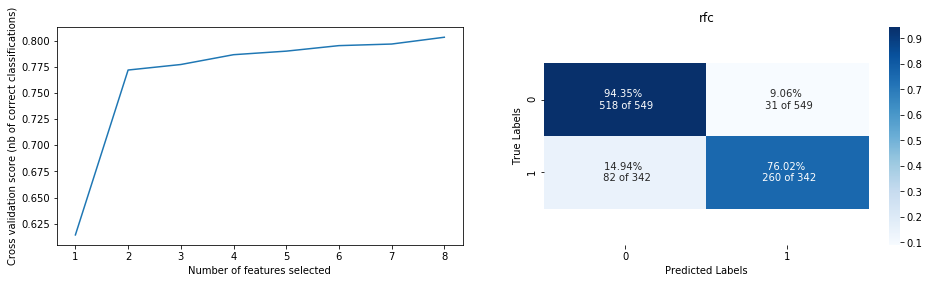

In [189]:
rfecv = feature_selection.RFECV(estimator=gbc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(gbc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

#### ExtraTreesClassifier

In [190]:
etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                               n_estimators=25,
                               max_depth=4,
                               ccp_alpha=0.0)
scores = cv_rep(etc, X, y, cv, scoring)
base_scores['etc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'n_estimators': np.arange(5, 100, 20),
#                 'max_depth': np.arange(3, 10)}
# etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.001,0.01, 15)}
# etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.818675  0.884504         0.829040
std_train            0.011282  0.011097         0.010647
mean_test            0.794307  0.858826         0.809571
std_test             0.023342  0.023911         0.025549


In [191]:
param_ranges = {'criterion': ['gini', 'entropy']}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.818703  0.884504         0.829700
std_train            0.010597  0.011097         0.010107
mean_test            0.795096  0.858826         0.810353
std_test             0.022976  0.023911         0.024826
{'criterion': 'gini'}


In [192]:
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.824758  0.941765         0.907219
std_train            0.011664  0.006171         0.008462
mean_test            0.796246  0.871762         0.818686
std_test             0.025384  0.019900         0.023794
{'max_depth': 5, 'n_estimators': 65}


In [193]:
param_ranges = {'ccp_alpha': np.linspace(0.001,0.01, 60)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.820771  0.895631         0.835915
std_train            0.011872  0.008807         0.010891
mean_test            0.795640  0.864242         0.811927
std_test             0.027102  0.022100         0.025643
{'ccp_alpha': 0.002220338983050848}


In [194]:
base_scores['etc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

Optimal number of features : 5
Features to drop: 

['Age', 'Fare', 'fgrp']


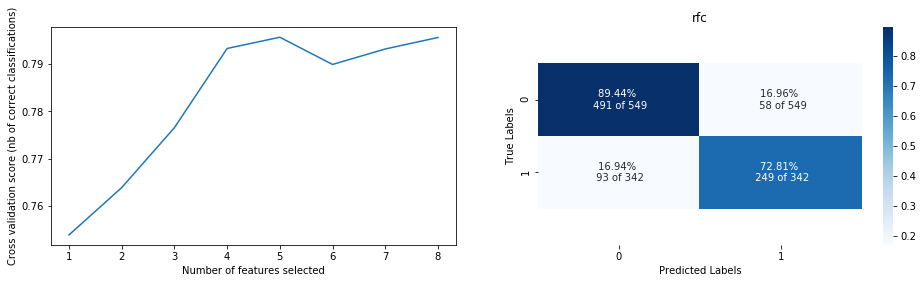

In [195]:
rfecv = feature_selection.RFECV(estimator=etc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(etc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

#### RandomForestClassifier

In [196]:
rfc = ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                                 n_estimators=45,
                                 max_depth=5,
                                 ccp_alpha=0.0112637)
scores = cv_rep(rfc, X, y, cv, scoring)
base_scores['rfc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'n_estimators': np.arange(5, 100, 20),
#                 'max_depth': np.arange(5, 10)}
# rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.001, 0.01, 15)}
# rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.829920  0.910660         0.858317
std_train            0.013286  0.008498         0.009519
mean_test            0.794954  0.866428         0.826913
std_test             0.028017  0.020118         0.024069


In [197]:
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(5, 10)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.832655  0.911300         0.863487
std_train            0.008477  0.008651         0.009924
mean_test            0.795560  0.868720         0.827839
std_test             0.027549  0.020902         0.026634
{'max_depth': 7, 'n_estimators': 25}


In [198]:
param_ranges = {'ccp_alpha': np.linspace(0, 1, 80)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.895478  0.965089         0.855132
std_train            0.017636  0.005652         0.011411
mean_test            0.794904  0.866031         0.824972
std_test             0.018886  0.015641         0.023070
{'ccp_alpha': 0.0}


In [199]:
base_scores['rfc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### LogisticRegression

In [200]:
lr = lm.LogisticRegression(class_weight=class_weights, random_state=random_state, n_jobs=-1,
                           penalty='l2',
                           solver='liblinear',
                           dual=False,
                           C=1.3122448979591839)
scores = cv_rep(lr, X, y, cv, scoring)
base_scores['lr'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'C': np.linspace(0.1, 10, 99), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
# lr, scores = train_best_model(lr, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.802870  0.854122         0.805772
std_train            0.011458  0.013630         0.012158
mean_test            0.788500  0.844116         0.794296
std_test             0.019164  0.023815         0.018592


In [201]:
param_ranges = {'C': np.linspace(0.1, 10, 99), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr, scores = train_best_model(lr, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.805421  0.859746         0.809704
std_train            0.012879  0.013871         0.013467
mean_test            0.792377  0.852071         0.800605
std_test             0.026066  0.022997         0.024628
{'C': 8.28265306122449, 'solver': 'lbfgs'}


In [202]:
base_scores['lr'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### PassiveAggressiveClassifier

In [203]:
pac = lm.PassiveAggressiveClassifier(class_weight=class_weights, random_state=random_state, n_jobs=-1,
                                     C=0.21020408163265308)
scores = cv_rep(pac, X, y, cv, scoring)
base_scores['pac'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'C': np.linspace(0.1, 1, 99)}
# pac, scores = train_best_model(pac, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.703352  0.757379         0.723612
std_train            0.036793  0.070637         0.040451
mean_test            0.690153  0.748864         0.711192
std_test             0.056034  0.096648         0.053288


In [204]:
param_ranges = {'C': np.linspace(0.1, 1, 99)}
pac, scores = train_best_model(pac, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.706974  0.770578         0.729479
std_train            0.032357  0.074146         0.039792
mean_test            0.694790  0.760562         0.717052
std_test             0.053264  0.095094         0.061142
{'C': 0.23775510204081635}


In [205]:
base_scores['pac'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### RidgeClassifier

In [206]:
rc = lm.RidgeClassifier(class_weight=class_weights, random_state=random_state,
                        alpha=11.122448979591837)
scores = cv_rep(rc, X, y, cv, scoring)
base_scores['rc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'alpha': np.linspace(10, 20, 99)}
# rc, scores = train_best_model(rc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.807001  0.857756         0.812169
std_train            0.010674  0.014064         0.010755
mean_test            0.792683  0.849941         0.799238
std_test             0.022044  0.022762         0.021288


In [207]:
param_ranges = {'alpha': np.linspace(0.1, 20, 99)}
rc, scores = train_best_model(rc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.807001  0.857203         0.812143
std_train            0.011019  0.013737         0.010882
mean_test            0.794016  0.851118         0.802138
std_test             0.022314  0.021933         0.021106
{'alpha': 7.004081632653061}


In [208]:
base_scores['rc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### SVC

In [209]:
svc = svm.SVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
              C=9428.57142857143)
scores = cv_rep(svc, X, y, cv, scoring)
base_scores['svc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'C': np.linspace(9000, 12000, 99)}
# svc, scores = train_best_model(svc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.825808  0.892942         0.834340
std_train            0.015767  0.014836         0.014730
mean_test            0.793889  0.838832         0.805801
std_test             0.026406  0.031957         0.027197


In [210]:
param_ranges = {'C': np.linspace(90000, 120000, 99)}
svc, scores = train_best_model(svc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.844542  0.909997         0.852572
std_train            0.013048  0.010898         0.012341
mean_test            0.788617  0.835872         0.797216
std_test             0.027331  0.033071         0.027161
{'C': 117857.14285714286}


In [211]:
base_scores['svc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [212]:
nusvc = svm.NuSVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
                 nu=0.5102089795918366)
scores = cv_rep(nusvc, X, y, cv, scoring)
base_scores['nusvc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'nu': np.linspace(0.00001,1,99)}
# nusvc, scores = train_best_model(nusvc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.815522  0.854014         0.830566
std_train            0.011295  0.013647         0.010489
mean_test            0.794604  0.840997         0.814519
std_test             0.022244  0.021076         0.022693


In [213]:
param_ranges = {'nu': np.linspace(0.00001,1,99)}
nusvc, scores = train_best_model(nusvc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.815762  0.854014         0.831861
std_train            0.011719  0.013647         0.011234
mean_test            0.798182  0.840997         0.818893
std_test             0.022226  0.021076         0.020849
{'nu': 0.4693930612244898}


In [214]:
base_scores['nusvc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [215]:
pd.DataFrame(base_scores, index=['test_score', 'train_score']).sort_values(by='test_score', axis=1,ascending=False)

,gbc,abc,nusvc,etc,rfc,rc,lr,lda,qda,svc,gpc,pac
test_score,0.803207,0.802736,0.798182,0.795640,0.794904,0.794016,0.792377,0.792245,0.788985,0.788617,0.737888,0.694790
train_score,0.857579,0.818392,0.815762,0.820771,0.895478,0.807001,0.805421,0.805943,0.808001,0.844542,0.842040,0.706974


In [216]:
# 	rfc	gbc	abc	nusvc	etc	lda	rc	svc	lr	qda	gpc	pac
# test_score	0.820896	0.820149	0.819030	0.817164	0.813806	0.811194	0.808209	0.807836	0.803731	0.798507	0.767537	0.683209
# train_score	0.851311	0.838764	0.834831	0.834644	0.834644	0.824906	0.820787	0.841199	0.817603	0.820412	0.875843	0.705243

In [217]:
# 	rfc	gbc	abc	etc	lda	rc	nusvc	lr	qda	svc	gpc	pac
# test_score	0.820896	0.820149	0.819030	0.815299	0.813433	0.812313	0.807090	0.806716	0.797388	0.784701	0.735075	0.679104
# train_score	0.851311	0.838764	0.834831	0.836517	0.823221	0.823034	0.835768	0.815918	0.820599	0.852809	0.908240	0.684644

In [218]:
# 	abc	rfc	gbc	nusvc	etc	lda	rc	lr	svc	qda	gpc	pac
# test_score	0.821642	0.818284	0.818284	0.817537	0.815672	0.812687	0.807090	0.802985	0.802612	0.792537	0.758209	0.700373
# train_score	0.836891	0.849438	0.840262	0.832397	0.835393	0.824906	0.819288	0.815169	0.840262	0.822846	0.873034	0.713483

In [219]:
# 	abc	nusvc	etc	rfc	lda	rc	gbc	lr	svc	qda	gpc	pac
# test_score	0.800065	0.795637	0.795216	0.793142	0.792245	0.790435	0.789676	0.787284	0.784063	0.776246	0.731039	0.695196
# train_score	0.818816	0.813514	0.818520	0.828079	0.807711	0.805542	0.815025	0.801738	0.825688	0.807142	0.851181	0.708093

In [220]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'rc':rc,'svc':svc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [221]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

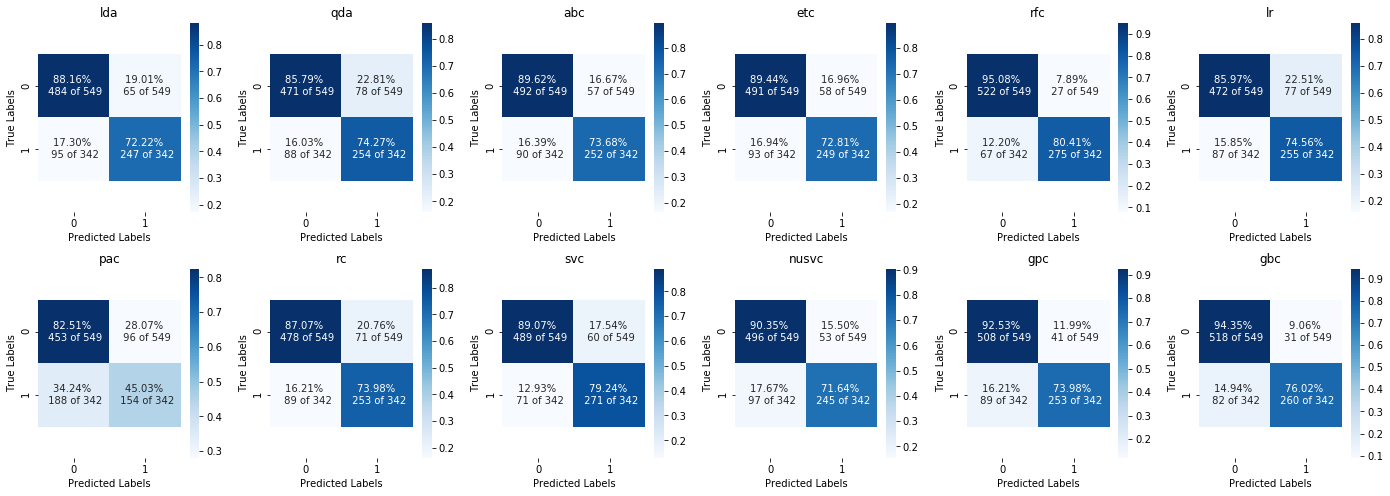

In [222]:
grd_n = len(base_models_surv)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(base_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

In [223]:
def base_models_predictions(models, X):
    X1 = None
    for i, model in models:
        if X1 is None:
            X1 = pd.Series(model.predict(X), name=i).to_frame()
        else:
            X1 = X1.merge(pd.Series(model.predict(X), name=i).to_frame(), left_index=True, right_index=True)
    return X1

In [224]:
def base_models_predictions_proba(models, X):
    X0 = None
    X1 = None
    for i, model in models:
        proba_0 = model.predict_proba(X)[:,0]
        proba_1 = model.predict_proba(X)[:,1]
        if X0 is None:
            X0 = pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame()
        else:
            X0 = X0.merge(pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
        
        if X1 is None:
            X1 = pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame()
        else:
            X1 = X1.merge(pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
    return (X0, X1)

#### Base estimators correlation matrix

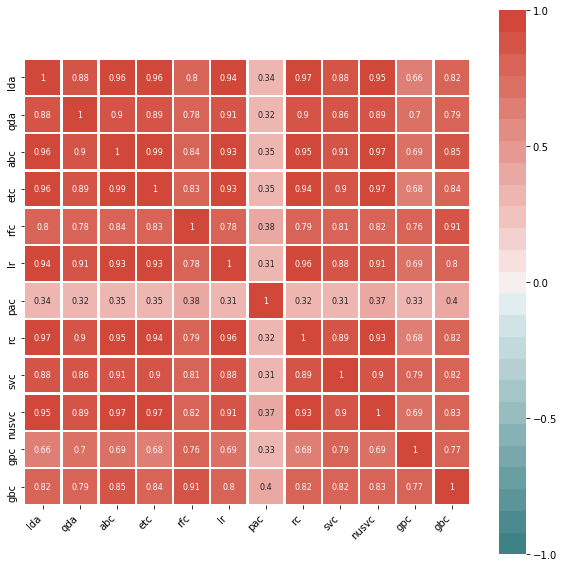

In [225]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [226]:
# Mean of each model correlation coefficients
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (corr_matrix[k].sum() - 1) / len(corr_matrix.index)
df_base_models_corr_sc = pd.DataFrame(corr_sc, index=['cc'])
df_base_models_corr_sc.sort_values(by='cc', axis=1, ascending=False)

,abc,etc,nusvc,lda,rc,lr,svc,qda,gbc,rfc,gpc,pac
cc,0.778739,0.773165,0.770003,0.76419,0.764026,0.753504,0.745403,0.735325,0.721059,0.709187,0.619668,0.314652


#### Select less correlated models

In [227]:
# base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'lr':lr,'pac':pac,'svc':svc}

In [228]:
base_models_surv_dic = {'qda':qda,'rfc':rfc,'lr':lr,'rc':rc,'svc':svc,'nusvc':nusvc,'gpc':gpc}

In [229]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

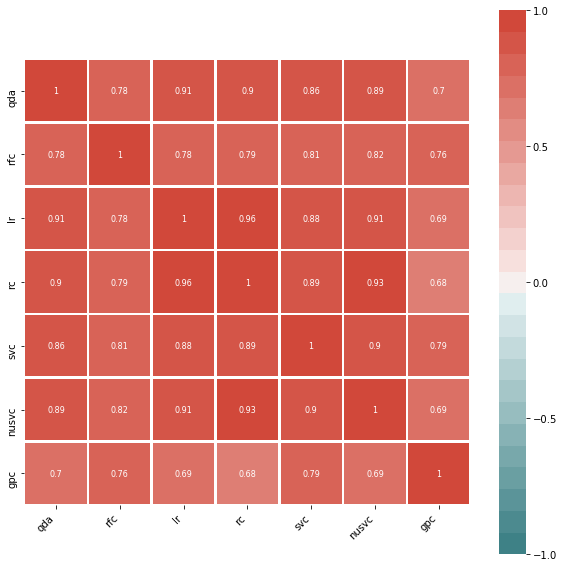

In [230]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

#### Compare stacking classifier score for different final estimator models

In [231]:
def train_final_models(models, X, y, score, cv_folds=5):
    scores = {}
    fin_models = []
    for m in models:
        model_st = ens.StackingClassifier(estimators=base_models_surv,
                                          final_estimator=m[1],
                                          cv=cv_folds, 
                                          stack_method='predict', 
                                          n_jobs=-1)
        res = cv_rep(model_st, X, y, cv, scoring)
        scores[m[0]] = [res.loc['mean_test', score], res.loc['mean_train', score]]
        fin_models.append((m[0], model_st))
    scores = pd.DataFrame(scores, index=['Test_score', 'Train_score']).sort_values(by='Test_score', axis=1,ascending=False)
    return fin_models, scores

In [232]:
final_models_surv = [('abc', ens.AdaBoostClassifier()),
                     ('gbc', ens.GradientBoostingClassifier()),
                     ('etc', ens.ExtraTreesClassifier()),
                     ('rfc', ens.RandomForestClassifier()),
                     ('lr', lm.LogisticRegression()),
                     ('svc', svm.SVC())]

In [233]:
fin_models, scores = train_final_models(final_models_surv, X, y, cv_folds=5, score=refit)

In [234]:
scores

,rfc,gbc,abc,lr,etc,svc
Test_score,0.799273,0.798791,0.797387,0.796784,0.796784,0.795631
Train_score,0.855798,0.855222,0.861601,0.856370,0.848025,0.852288


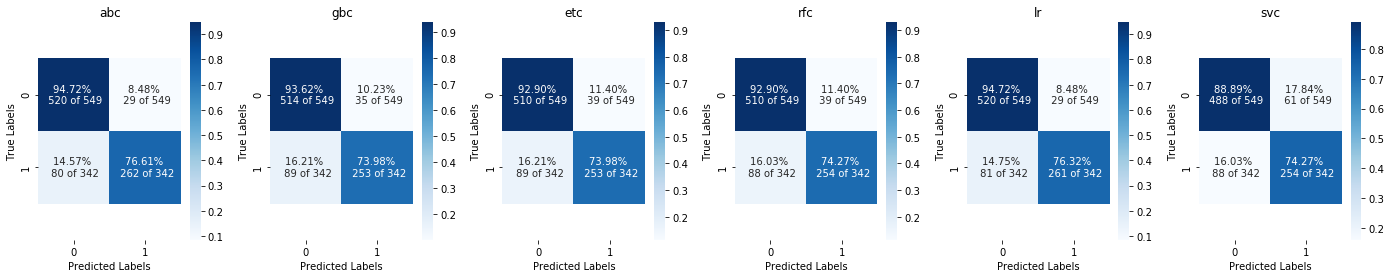

In [235]:
grd_n = len(fin_models)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(fin_models):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

#### Train stacking model

In [236]:
model_st = ens.StackingClassifier(estimators=base_models_surv,
                                  final_estimator=ens.AdaBoostClassifier(algorithm='SAMME.R', 
                                                                         learning_rate=0.1,
                                                                         n_estimators=25,
                                                                         random_state=random_state),
                                  cv=5, 
                                  stack_method='predict', 
                                  passthrough=False,
                                  n_jobs=-1)

# param_ranges = {'final_estimator__n_estimators': np.arange(5, 100, 20), 'final_estimator__learning_rate': np.linspace(0.001, 1, 40)}
# model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.863712,0.898932,0.887519
std_train,0.017410,0.017775,0.024215
mean_test,0.798726,0.842780,0.822038
std_test,0.019499,0.018489,0.022568


In [237]:
param_ranges = {'final_estimator__n_estimators': np.arange(5, 120, 50), 'final_estimator__learning_rate': np.linspace(0.001, 0.5, 70)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)


            balanced_accuracy   roc_auc  precision_macro
mean_train           0.860948  0.900062         0.890265
std_train            0.019155  0.016912         0.019098
mean_test            0.802065  0.844319         0.824975
std_test             0.019135  0.019679         0.022373
{'final_estimator__learning_rate': 0.4566086956521739, 'final_estimator__n_estimators': 5}


In [238]:
# 	balanced_accuracy	roc_auc	precision_macro
# mean_train	0.821064	0.852050	0.836468
# std_train	0.011899	0.019283	0.011571
# mean_test	0.799821	0.816190	0.819587
# std_test	0.022534	0.025011	0.021100

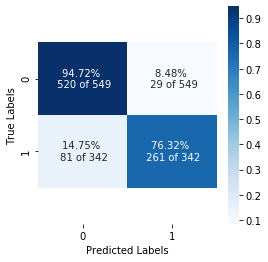

In [239]:
fig = plt.figure()
fig.set_size_inches(4,4)
plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

In [240]:
model_st_cal = calib.CalibratedClassifierCV(base_estimator=model_st, method='sigmoid', cv=cv)
model_st_cal.fit(X,y)
cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.860948,0.900062,0.882067
std_train,0.019155,0.016912,0.027244
mean_test,0.802065,0.844319,0.823208
std_test,0.019135,0.019679,0.020200


## Predict test set

#### Preprocessind data

In [241]:
data = family_groups_encoder(data_test.copy(), fgrp_mask)
# data = family_encoder(data)
# data = fare_encoder(data, [sig1, fam1, famch1])
data = fare_encoder(data, fare_mask)
data = fare_transformer(data)

data = ticket_encoder(data, ticket_mask)

data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)

data = embarked_encoder(data)
data = pclass_encoder(data)
data = combine_features(data, 'Pclass', 'Embarked', 'PclEmb')

# data = data[data['Age'].notna()].copy()
# data = data[['Age', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Cabin', 'PassengerId']]

data = age_predictor(data, age_cls_model, age_reg_mogel)
# data = age_transformer(data, age_clast_model)
# data = data[['PassengerId', 'Survived', 'Fare', 'Age', 'ttl', 'famsize', 'PclEmb', 'fgrp']]
data = data[['PassengerId', 'Age', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket']]

In [242]:
# data = family_groups_encoder(data_test, fam_grps)
# data = fare_encoder(data, [sig1, fam1, famch1])
# data = fare_transformer(data)

# data = title_encoder(data)
# data = sex_encoder(data)
# data = fam_size(data)

# data = embarked_encoder(data)
# data = pclass_encoder(data)
# data = combine_features(data, 'Pclass', 'Embarked', 'PclEmb')

# data = data[['PassengerId', 'Fare', 'Age', 'ttl', 'famsize', 'PclEmb', 'fgrp']]

# data = age_predictor(data, age_cls_model, age_reg_mogel)
# data = age_transformer_counts(data)

#### Make predictions

In [243]:
X = data.drop(columns=['PassengerId'])

In [244]:
data['Survived'] = model_st.predict(X)
df_submission = data[['PassengerId', 'Survived']]
df_submission.to_csv("df_submission.csv", index=False)

In [163]:
df_submission.loc[df_submission['PassengerId']>890]

,PassengerId,Survived
0,902,0
1,914,1
2,921,0
3,925,1
4,928,1
...,...,...
409,1301,1
411,1303,1
412,1304,1
414,1306,1


In [250]:
df_pp = pd.DataFrame(model_st_cal.predict_proba(X), columns=['pp_0', 'pp_1'])
df_pp = pd.concat([data['PassengerId'].reset_index(drop=True), df_pp], axis=1)
df_pp.to_csv("df_pp.csv", index=False)

In [5]:
df_pp

,PassengerId,pp_0,pp_1
0,902,0.685302,0.314698
1,914,0.326434,0.673566
2,921,0.685302,0.314698
3,925,0.418080,0.581920
4,928,0.326434,0.673566
...,...,...,...
413,1301,0.418080,0.581920
414,1303,0.326434,0.673566
415,1304,0.326434,0.673566
416,1306,0.326434,0.673566


In [4]:
# Import predicted probabilities
filename_pp = 'df_pp.csv'
df_pp = pd.read_csv(filename_pp)

In [8]:
df_pp.loc[df_pp['pp_1'] > 70]

,PassengerId,pp_0,pp_1
